In [1]:
%run forward_simulation.ipynb
%run pid_controller.ipynb

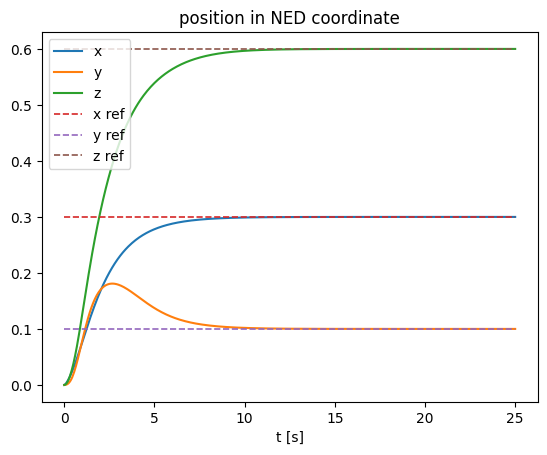

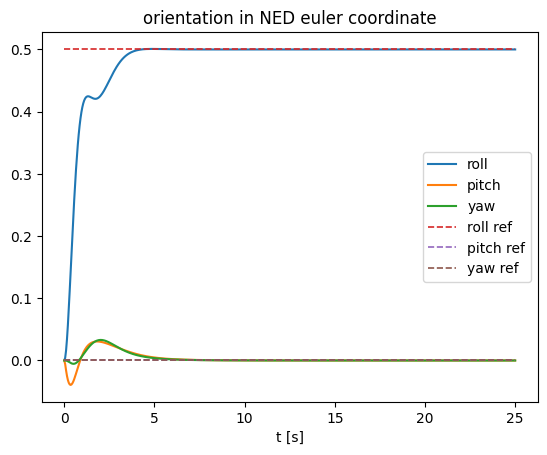

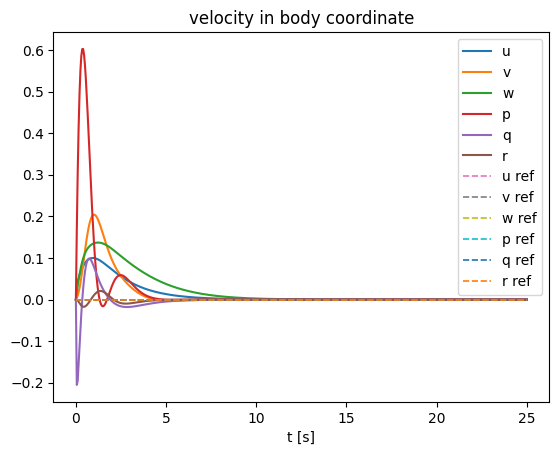

In [3]:
blue.T = 25
blue_dt = 0.05
blue.N = int(np.ceil(blue.T / blue_dt))


uv_sim_reg = Fsim_reg(sim_x, pid_control_reg, sim_p_reg, dt, f_ext)
cl_sys = ca.Function('cl_system', [sim_x, nd, xb_d, Kp, Ki, Kd, sim_p_reg, dt, f_ext, sum_e_buffer], [uv_sim_reg])
cl_sim = cl_sys.mapaccum(blue.N)
cl_sim.save("uv_rollout_sim_reg.casadi")

uv_desired = np.array([0.3, 0.1, 0.6, 0.5, 0.0, 0.0])  # [x,y,z,roll,pitch,yaw]
uv_desired_body_vel = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
x0 = np.array([0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # x y z r p y u v w p q r
sebuffer_ = np.array([0,0,0,0,0,0])
f_ext_0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

res = cl_sim(x0, uv_desired, uv_desired_body_vel, blue.real_kp, blue.real_ki, blue.real_kd, blue.sim_params_id, blue_dt, f_ext_0, sebuffer_)
X = np.concatenate((x0.reshape((12,1)), res.toarray()), axis=1)  # shape 12 x (N+1)

t = np.linspace(0, blue.T, blue.N+1)

# build reference arrays with same length as X time axis
pos_ref = np.tile(uv_desired[:3].reshape(3,1), (1, X.shape[1]))              # x,y,z
eul_ref = np.tile(uv_desired[3:6].reshape(3,1), (1, X.shape[1]))             # roll,pitch,yaw
vel_ref = np.zeros((6, X.shape[1]))                                          # u,v,w,p,q,r

# position plot
plt.figure()
plt.plot(t, X[0:3, :].T, linewidth=1.5)
plt.plot(t, pos_ref.T, linestyle='--', linewidth=1.2)
plt.legend(['x', 'y', 'z', 'x ref', 'y ref', 'z ref'])
plt.title('position in NED coordinate')
plt.xlabel('t [s]')

# orientation plot
plt.figure()
plt.plot(t, X[3:6, :].T, linewidth=1.5)
plt.plot(t, eul_ref.T, linestyle='--', linewidth=1.2)
plt.legend(['roll', 'pitch', 'yaw', 'roll ref', 'pitch ref', 'yaw ref'])
plt.title('orientation in NED euler coordinate')
plt.xlabel('t [s]')

# body velocities plot
plt.figure()
plt.plot(t, X[6:, :].T, linewidth=1.5)
plt.plot(t, vel_ref.T, linestyle='--', linewidth=1.2)
plt.legend(['u', 'v', 'w', 'p', 'q', 'r', 'u ref', 'v ref', 'w ref', 'p ref', 'q ref', 'r ref'])
plt.title('velocity in body coordinate')
plt.xlabel('t [s]')

plt.show()